# Portfolio Selection via Text-Based Networks

# 1. Data Processing


In [1]:
# basic
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
import time
import glob
import os
from numpy.linalg import inv

# user-defined
from agent_network import *
from environment import market_envrionment
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# visulization
import igraph
import cairocffi
# import cairo
import matplotlib.pyplot as plt

## 1.1 Load stock information

In [23]:
file_path = '../data/'
# load TBN tickers
file_name = 'gvkey_ticker.csv'
tickers_info = pd.read_csv(file_path + file_name,  header=0, usecols=[1, 2], index_col = [0], engine='c')
tickers_info = tickers_info.loc[~tickers_info.index.duplicated(keep='first')]

# load stock data
file_name = 'stock_data.csv'
stock_data = pd.read_csv(file_path + file_name,  header=0, index_col=[0], engine='c')
tickers_subset = stock_data.dropna(axis='columns').columns
tickers_key = tickers_info.loc[tickers_subset].gvkey.values

# load market data
file_name = 'F-F_Research_Data_Factors_daily.csv'
interest_rate = pd.read_csv(file_path + file_name,  header=0, usecols=[0, 4], index_col=[0], engine='c').dropna()
date_format = '%Y%m%d' # Y for year, m for month, d for day
rf_date = pd.Index([datetime.strptime(str(x), date_format) for x in interest_rate.index])
interest_rate.index = rf_date

In [24]:
# load TBN data
file_path = '../data/'
file_type = 'TBN_*.csv'
file_list = glob.glob(file_path + file_type)

idx = pd.Index
tbn_combined = pd.DataFrame()
for file in file_list:
    year = int(file.split('/')[-1][4:8]) # not safe expression
    tbn = pd.read_csv(file,  header = 0, index_col = [0], engine='c')
    np.fill_diagonal(tbn.values, 0)
    row_num = tbn.shape[0]
    year_idx = idx(np.repeat(year, row_num))
    tbn.set_index(year_idx, append = True, inplace = True)
    tbn_combined = tbn_combined.append(tbn)
tbn_combined = tbn_combined.reorder_levels(order=[1,0])

## *1.2 Extract related TBN(Needed for the first time)
Loop from 1999 to  2017, extract related info according to gvkey for each year. The resuts are going to be reformated to a 26 by 26 matrix for each year. However, HON doesn't included in TNIC network. So the final results are 25 by 25 matrix.

In [243]:
def extract_TNIC_network_subset(key_list):

        # initialization
        OUTPUT_FILE_PATH = os.getcwd() + '/' + 'data/'
        OUTPUT_FILE_TYPE = '.csv'
        TARGET_FOLDER_PATH = "/Users/cheng/Documents/Research/Text Base Network/tnic_all_data/TNIC_AllPairsDistrib/"
        TARGET_FILE_TYPE = "*.txt"
        file_list = glob.glob(TARGET_FOLDER_PATH + TARGET_FILE_TYPE)
        idx = pd.IndexSlice


        for file in file_list:

                # read data
                data = pd.read_csv(file, sep="\t", header=0, usecols=[0, 1, 2], index_col=[1, 2], engine='c')
                
                # extract selected data
                scores_year = data.loc[idx[key_list, key_list], ] # a long vector

                # modification
                scores_year = scores_year.unstack() # convert vector to matrix
                scores_year.columns.names = [None,None] # clear multi column index 
                scores_year.index.names = [None] # clear index head name
                scores_year.columns = scores_year.index 
                np.fill_diagonal(scores_year.values, 1) # fill diagnoal with value 1
                scores_year = scores_year.replace([np.NaN], 0)

                # save data
                if not os.path.exists(OUTPUT_FILE_PATH):
                        os.makedirs(OUTPUT_FILE_PATH)
                
                IDENTIFIER =file.split('/')[-1][-8:-4]
                scores_year.to_csv(OUTPUT_FILE_PATH + IDENTIFIER + OUTPUT_FILE_TYPE)


In [244]:
extract_TNIC_network_subset(tickers_key)

## *1.3 Load TBN data
define function to get TBN data from files

In [16]:
def get_text_based_network(year):
    
    year_str = str(year)
    TARGET_FOLDER_PATH = "../data/"
    TARGET_FILE_TYPE = "TBN_*.csv"
    file_list = glob.glob(TARGET_FOLDER_PATH + TARGET_FILE_TYPE)

    file_idx = [year_str in x for x in file_list]
    file_path = np.array(file_list)[file_idx] # np.array index using bool vector
    data = pd.read_csv(file_path[0], header=0, index_col=[0], engine='c')

    return(data)


# 2 Networks
## 2.1 Correlation-Based Networks
**Data processing at first**

In [25]:
# Na value
stock_data = stock_data.dropna(axis='columns') # drop incomplete data to form 26 columns

# set year as index 
date_format = '%Y-%m-%d' # Y for year, m for month, d for day
stock_date = pd.Index([datetime.strptime(x, date_format) for x in stock_data.index])
stock_data.index = [x.year for x in stock_date]

# calculate stock returns
stock_returns = stock_data.pct_change().dropna(axis='rows')

**compute correlation matrix for stock return**

In [26]:
correlation_aggregate = stock_returns.groupby(level=0).corr()
volatility_aggregate = stock_returns.groupby(level=0).std()
covariance_aggregate = stock_returns.groupby(level=0).cov()

correlation_return_1996 = correlation_aggregate.loc[1996]
correlation_return_2008 = correlation_aggregate.loc[2008]

**plot adjacient graph**

In [8]:
def adjacency_plot(matrix, thredshould, output_name):
    # matrix modification
    t = thredshould
    A = matrix[matrix.abs() > t].fillna(0).values # passing a np array

    # build graph
    #g = igraph.Graph.Adjacency(matrix = (A > 0).tolist(),mode='UNDIRECTED')
    g = igraph.Graph.Weighted_Adjacency(matrix = A.tolist(), mode='UNDIRECTED')
    g.es['weight'] = A
    g.vs['label'] = matrix.index

    # layout control
    visual_style = {}
    visual_style["vertex_size"] = 25
    visual_style["vertex_label_size"] = 10
    visual_style["edge_width"] = 0.5
    visual_style["autocurve"] = False
    visual_style["label"] = True
    visual_style["layout"] = 'kk'
    visual_style["bbox"] = (600, 600)
    visual_style["margin"] = 80

    # save file
    file_prefix = os.getcwd() + '/' + 'picture/'
    file_suffix = '.png'

    return(igraph.plot(g,file_prefix + output_name + file_suffix ,**visual_style)) # return a graph, no return no plot

** plot 1996 graph**

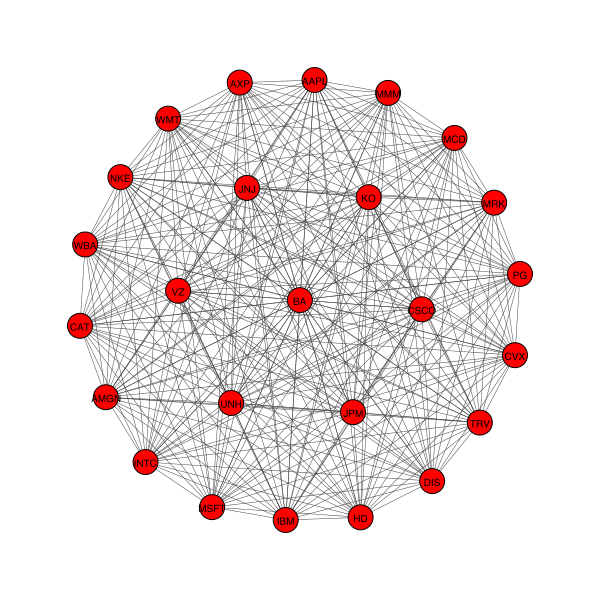

In [14]:
# input
np.fill_diagonal(correlation_return_1996.values, 0)
parameters = {}
parameters['matrix'] = correlation_return_1996
parameters['thredshould'] = 0
parameters['output_name'] = 'stock_return_correlation_network_1996'

# output
adjacency_plot(**parameters)

**plot 2008 plot**

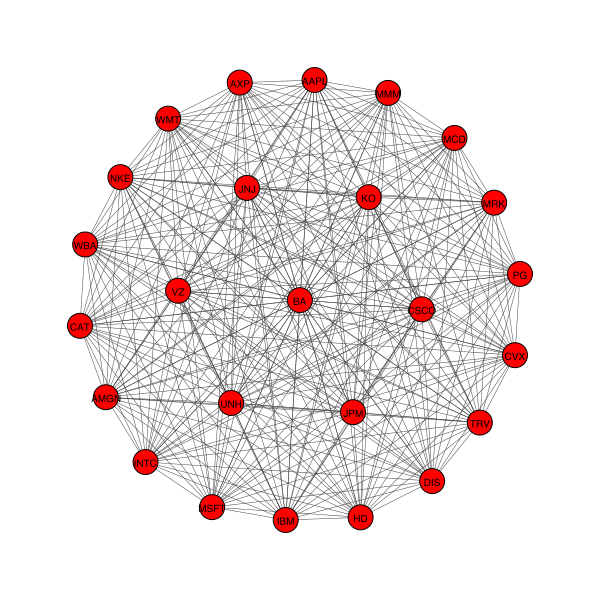

In [15]:
# input
np.fill_diagonal(correlation_return_2008.values, 0)
parameters = {}
parameters['matrix'] = correlation_return_2008
parameters['thredshould'] = 0
parameters['output_name'] = 'stock_return_correlation_network_2008'

# output
adjacency_plot(**parameters)

** Remove all correlation below 0.5**

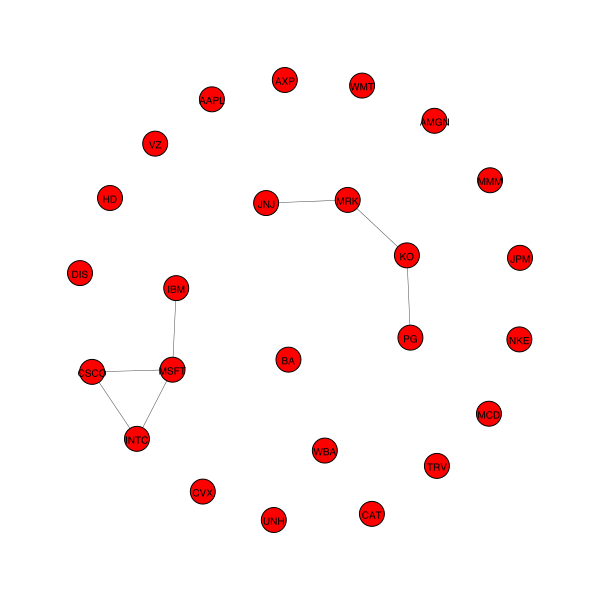

In [22]:
# input
parameters = {}
parameters['matrix'] = correlation_return_1996
parameters['thredshould'] = 0.5
parameters['output_name'] = 'stock_return_correlation_network_1996_parse_2'

# output
adjacency_plot(**parameters)

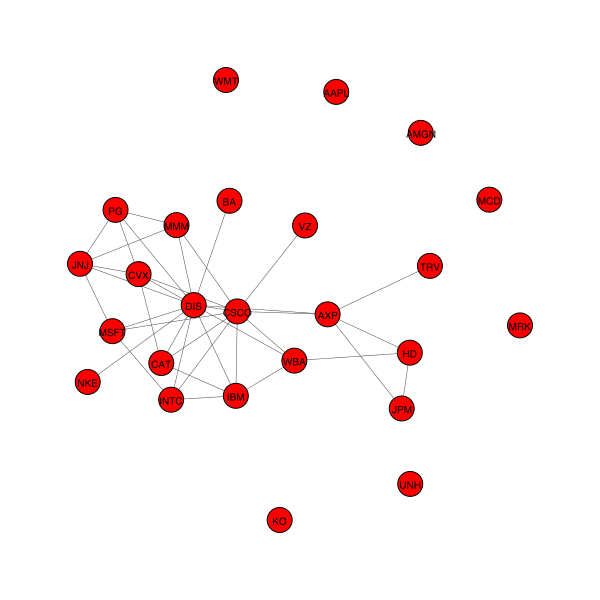

In [24]:
# input
parameters = {}
parameters['matrix'] = correlation_return_2008
parameters['thredshould'] = 0.7
parameters['output_name'] = 'stock_return_correlation_network_2008_parse_2'

# output
adjacency_plot(**parameters)

## 2.2 Text-Based Networks

In [6]:
correlation_text_1996 = get_text_based_network(1996)
correlation_text_2008 = get_text_based_network(2008)

correlation_text_1996.index = correlation_return_1996.index
correlation_text_2008.index = correlation_return_1996.index
np.fill_diagonal(correlation_text_1996.values, 0)
np.fill_diagonal(correlation_text_2008.values, 0)


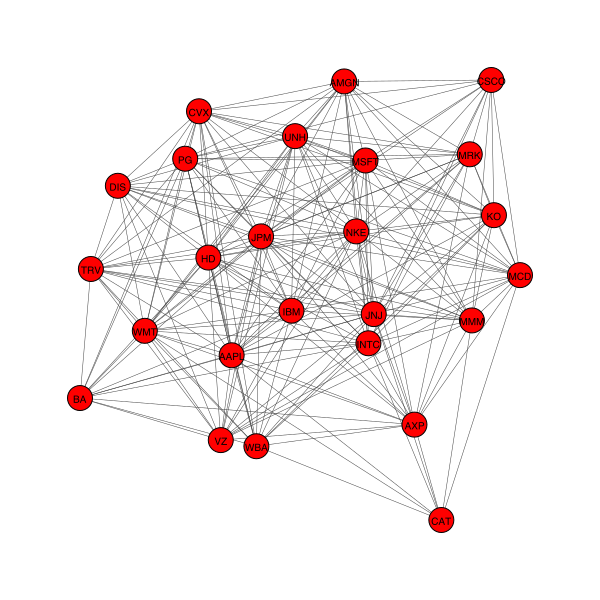

In [34]:
# input
parameters = {}
parameters['matrix'] = correlation_text_1996
parameters['thredshould'] = 0
parameters['output_name'] = 'text_correlation_network_1996'

# output
adjacency_plot(**parameters)

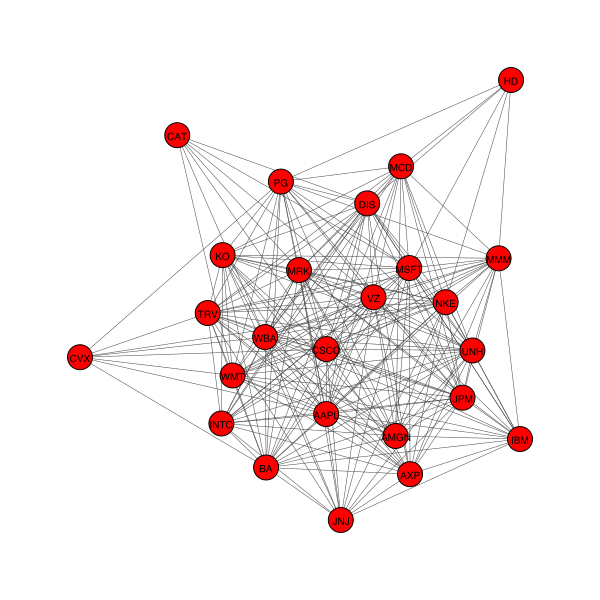

In [33]:
# input
parameters = {}
parameters['matrix'] = correlation_text_2008
parameters['thredshould'] = 0
parameters['output_name'] = 'text_correlation_network_2008'

# output
adjacency_plot(**parameters)

# 3. Back-testing
**Buid the GMV portfolio as a function of intensity $\alpha$**

In [7]:
def GMVP(a, correlated_matrix_stock, correlated_matrix_text, volatility_vector):
    '''GMV portfolio as a function of intensity 'alpha'
    Args:
        a: alpha
        correlated_matrix_stock: correlation matrix of stock returns
        correlated_matrix_text: TBN
        volatility_vector: volatility of stock returns
    Returns:
        GMVP(column vector)
    '''
    # initialization
    R_1 = correlated_matrix_stock.values
    R_2 = correlated_matrix_text.values
    D = np.diag(volatility_vector) 
    one = np.ones(D.shape[0])

    # pre calculation
    R_3 = (1 - a) * R_1 + a * R_2 # new shrank correlated matrix
    H = D @ R_3 @ D # new shrank covariance matrix
    H_inv = inv(H)
    numerator = H_inv @ one
    denominator = one.T @ H_inv @ one

    # GMV porfolio
    x = numerator / denominator

    #return pd.DataFrame(H)
    return x.reshape((len(x), 1))

**build back testing function**

In [9]:
def back_test_on_portfolio_return(start, end, alpha_step):
    '''Build GMVP at the end of each year and compute portfolio return on the next year

    Required function:
        GMVP - calculate portfolio weights
        get_text_based_network - need for GMVP
    Args:
        start: beginning year
        end: ending year
        alpha_step: increment step for alpha range
    Returns:
        daily portfolio return time series
        n * 252 time series (n: # of alpha range)
    '''

    # initialization
    year_range = np.arange(start, end + 1)
    alpha_range = np.arange(0, 1 + alpha_step, alpha_step)
    INFO = pd.DataFrame()
    portfolio = pd.DataFrame()

    for alpha in alpha_range:
        
        R_p = np.array([]) # to store portfolio's return series for each alpha
        gmv_p = np.array([])

        for i in year_range:

            # calculate GMV portfolio
            parameter_list = {}
            parameter_list['a'] = alpha
            parameter_list['correlated_matrix_stock'] = correlation_aggregate.loc[i]
            parameter_list['correlated_matrix_text'] = get_text_based_network(i)
            parameter_list['volatility_vector'] = volatility_aggregate.loc[i]
            x = GMVP(**parameter_list).T # 1 by n row vector
            
            # get stock return for the next year
            Y = stock_returns.loc[i + 1].values.T # n by 252 matrix
            #index = stock_returns.loc[i + 1].index

            # compute portfolio return for the next year
            r_p = x @ Y

            # store return series
            R_p = np.append(R_p, r_p)
            #gmv_p = np.append(gmv_p, correlation_stock_i.iloc[0,0])

        INFO[str(alpha)] = R_p
        #portfolio[str(alpha)] = gmv_p

    # index return series with date
    start = stock_date.searchsorted(datetime(start + 1, 1, 1))
    end = stock_date.searchsorted(datetime(end + 2, 1, 1))
    #date_index = stock_date[start:end][0:INFO.shape[0]]
    date_index = stock_date[start:end]
    INFO.index = date_index

    return INFO

**Build function to compute Sharpe Ratio**

In [28]:
def sharpe_ratio(stock_return):
    '''Given portfolio daily returns to calculate Sharpe ratio

    Argument:
        stock_return: a matrix that each column reperents a time series given specific portfolio
    Requirement:
        interest_rate matrix as risk free rate
    Return:
        pd.DataFrame (N x 1)

    '''

    # initialization
    date_idx = stock_return.index
    r_f = interest_rate.loc[date_idx].values.flatten()
    alpha_range = stock_return.shape[1] # changed from return_series.shape[1]
    sharpe_ratio_series = {} # SR container

    for i in np.arange(0, alpha_range):

        # initialization
        return_list = stock_return.iloc[:,i]
        alpha = return_list.name
        
        # calculate annual SR
        excess_return = return_list - r_f * 0.01
        expected_return = excess_return.mean() * 252
        volatility = excess_return.std()* np.sqrt(252)
        sharpe_ratio = expected_return / volatility
        
        # store SR
        sharpe_ratio_series[alpha] = sharpe_ratio

    temp = pd.DataFrame(sharpe_ratio_series, index=['SR']).T
    
    return temp


**Build plot function to visulize Sharpe ratio as a function of $\alpha$**

In [14]:
def sharpe_ratio_show(vector, title):
    # initialization
    output_path = '../picture/'
    output_name = output_path + title + '.jpg'

    # plot
    #fig = plt.figure()
    fig = vector.plot.line()
    plt.title(title)
    plt.ylabel('Annual Sharpe Ratio')
    plt.xlabel('$\\alpha$ range')
    # plt.savefig(output_name)
    plt.show()

** Back testing on different periods**

In [13]:
SR_aggregate = pd.DataFrame()

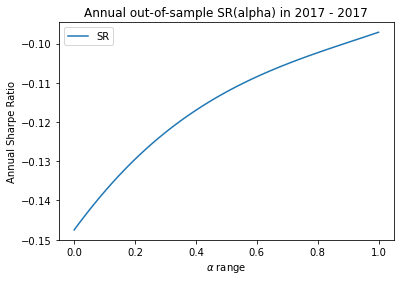

In [38]:
year += 1
parameter_list = {}
parameter_list['start'] = year
parameter_list['end'] = year
parameter_list['alpha_step'] = 0.01

# calculate portfolio return for different alpha
return_series = back_test_on_portfolio_return(**parameter_list)

# calculate Sharpe ratio for different alpha
SR = sharpe_ratio(return_series)

# store
SR_aggregate[year] = SR.values.flatten()

# plot Sharpe ratio as a function of alpha
file_name = 'Annual out-of-sample SR(alpha) in ' + str(parameter_list['start']) + ' - ' + str(parameter_list['end'])
sharpe_ratio_show(SR, file_name)

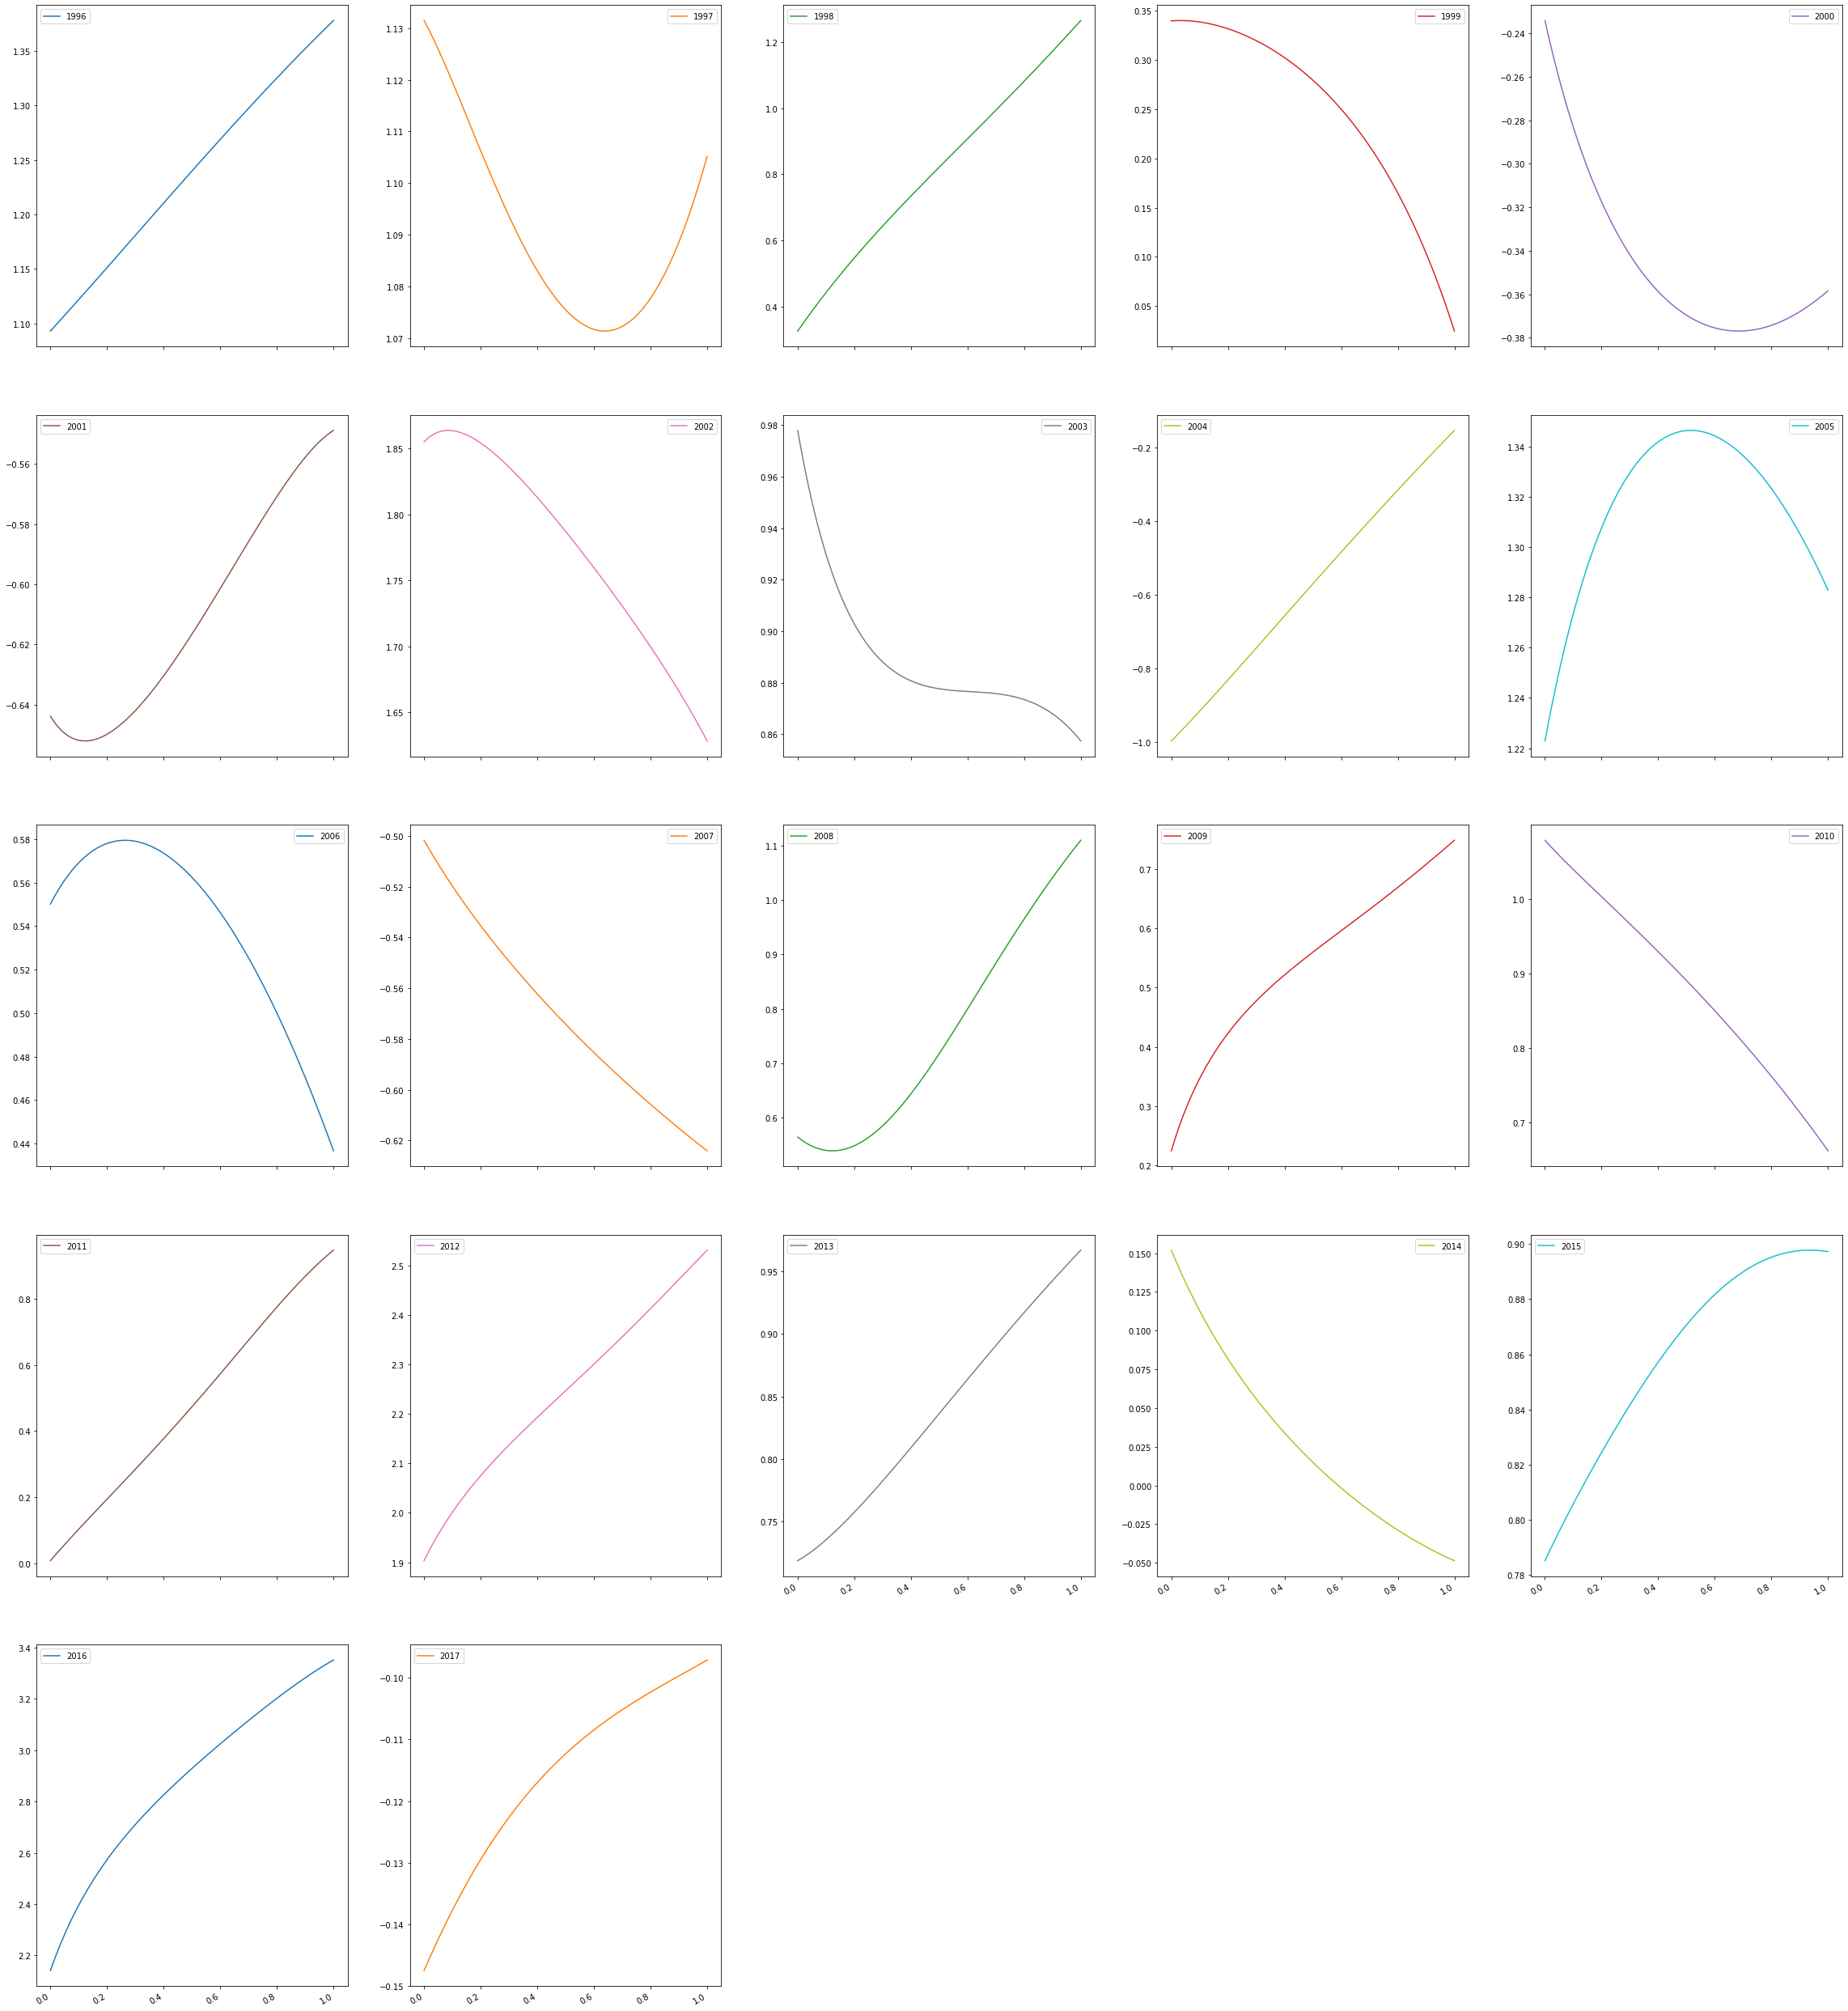

In [355]:
index = np.arange(0, 1.01, 0.01)
SR_aggregate.index = index
xtickers = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
title = 'Sharpe ratio SR($\\alpha$) on years from 1996 to 2017'
fig = SR_aggregate.plot(subplots = True,
                        use_index = True,
                        xticks = xtickers,
                        fontsize = 10,
                        layout = (5,5), 
                        figsize = (40,50))

In [39]:
sharpe_ratio_optimums = SR_aggregate.idxmax(axis=0)

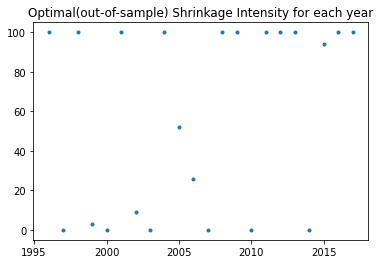

In [40]:
test = sharpe_ratio_optimums.plot(style = '.',
                           title = 'Optimal(out-of-sample) Shrinkage Intensity for each year')

# test.figure.savefig('../picture/Optimal(out-of-sample) Shrinkage Intensity for each year.jpg')

# 4. Scaler Analysis

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

## 4.1 scaled data function

In [ ]:
def get_scaled_data(X):
    distributions = [
        ('Unscaled data', X),
        ('Data after standard scaling',
            StandardScaler().fit_transform(X)),
        ('Data after min-max scaling',
            MinMaxScaler().fit_transform(X)),
        ('Data after max-abs scaling',
            MaxAbsScaler().fit_transform(X)),
        ('Data after robust scaling',
            RobustScaler(quantile_range=(25, 75)).fit_transform(X)),
        ('Data after power transformation (Yeo-Johnson)',
        PowerTransformer(method='yeo-johnson').fit_transform(X)),
        #('Data after power transformation (Box-Cox)',
        # PowerTransformer(method='box-cox').fit_transform(X)),
        ('Data after quantile transformation (gaussian pdf)',
            QuantileTransformer(output_distribution='normal')
            .fit_transform(X)),
        ('Data after quantile transformation (uniform pdf)',
            QuantileTransformer(output_distribution='uniform')
            .fit_transform(X)),
        ('Data after sample-wise L2 normalizing',
            Normalizer().fit_transform(X)),
    ]

    return distributions

In [ ]:
scaler_name_list = ['standard scaling',
                    'min-max scaling',
                    'max-abs scaling',
                    'robust scaling',
                    'power transformation',
                    'quantile transformation (gaussian pdf)',
                    'quantile transformation (uniform pdf)',
                    'sample-wise L2 normalizing',
                    'identity matrix']

## 4.2 scaled data

In [ ]:
tbn_1996 = tbn_combined.loc[1996].values
tbn_2008 = tbn_combined.loc[2008].values
tbn_1996_scaled_list = get_scaled_data(tbn_1996)
tbn_2008_scaled_list = get_scaled_data(tbn_2008)

## 4.3 plot scaled distribution

In [ ]:
fig, axs = plt.subplots(9, 2, figsize=(20, 40), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace = .4)
title = 'scaled TBN in 1996 and 2008'
#fig.suptitle(title)
axs = axs.ravel()

for i in range(9):
    text, data = tbn_1996_scaled_list[i]
    axs[i * 2].hist(data.flatten(), color='grey', ec='grey', weights = weights)
    axs[i * 2].set_title(text + ' in 1996')
    axs[i * 2].set_xlabel('scaled correlation')
    axs[i * 2].set_ylabel('distribution')

    text, data = tbn_2008_scaled_list[i]
    axs[i * 2 + 1].hist(data.flatten(), color='grey', ec='grey', weights = weights)
    axs[i * 2 + 1].set_title(text + ' in 2008')
    axs[i * 2 + 1].set_xlabel('scaled correlation')
    axs[i * 2 + 1].set_ylabel('distribution')

output_path = '../picture/'
output_name = output_path + title + '.jpg'
fig.savefig(output_name)

## 4.4 TBN Scale
Scale TBN for each year

In [ ]:
tbn_scaled_yearly_combined = {}
for i in range(1996, 2018):
    tbn_year = tbn_combined.loc[i]
    tbn_scaled_list = get_scaled_data(tbn_year) # both text and data
    tbn_scaled_list.pop(0)
    tbn_scaled_data = [pd.DataFrame(data) for text, data in tbn_scaled_list]
    tbn_scaled_data.append(pd.DataFrame(np.identity(23))) # not safe number
    tbn_scaled_yearly_combined[i] = tbn_scaled_data

Re-define back testing function

In [ ]:
def back_test_on_portfolio_return(start, end, alpha_step):
    '''Build GMVP at the end of each year and compute portfolio return on the next year

    Required function:
        GMVP - calculate portfolio weights
        get_text_based_network - need for GMVP
    Args:
        start: beginning year
        end: ending year
        alpha_step: increment step for alpha range
    Returns:
        daily portfolio return time series
        n * 252 time series (n: # of alpha range)
    '''

    # initialization
    year_range = np.arange(start, end + 1)
    alpha_range = np.arange(0, 1 + alpha_step, alpha_step)
    INFO = pd.DataFrame()
    portfolio = pd.DataFrame()

    for alpha in alpha_range:
        
        R_p = np.array([]) # to store portfolio's return series for each alpha
        gmv_p = np.array([])

        for i in year_range:

            # calculate GMV portfolio
            parameter_list = {}
            parameter_list['a'] = alpha
            parameter_list['correlated_matrix_stock'] = correlation_aggregate.loc[i]
            parameter_list['correlated_matrix_text'] = tbn_scaled_yearly_combined[i][SCALER_NUM] # change number to control scaler
            parameter_list['volatility_vector'] = volatility_aggregate.loc[i]
            x = GMVP(**parameter_list).T # 1 by n row vector
            
            # get stock return for the next year
            Y = stock_returns.loc[i + 1].values.T # n by 252 matrix
            #index = stock_returns.loc[i + 1].index

            # compute portfolio return for the next year
            r_p = x @ Y

            # store return series
            R_p = np.append(R_p, r_p)
            #gmv_p = np.append(gmv_p, correlation_stock_i.iloc[0,0])

        INFO[str(alpha)] = R_p
        #portfolio[str(alpha)] = gmv_p

    # index return series with date
    start = stock_date.searchsorted(datetime(start + 1, 1, 1))
    end = stock_date.searchsorted(datetime(end + 2, 1, 1))
    #date_index = stock_date[start:end][0:INFO.shape[0]]
    date_index = stock_date[start:end]
    INFO.index = date_index

    return INFO

## 4.5 back testing on different scalers

In [ ]:
def optimal_shrinkage_intensity_on_scalers(scaler_name):

    SR_aggregate = pd.DataFrame()
    alpha_step = 0.01

    # back testing
    for i in range(1996, 2018):
        year = i
        parameter_list = {}
        parameter_list['start'] = year
        parameter_list['end'] = year
        parameter_list['alpha_step'] = alpha_step

        # calculate portfolio return for different alpha
        return_series = back_test_on_portfolio_return(**parameter_list)

        # calculate Sharpe ratio for different alpha
        SR = sharpe_ratio(return_series)

        # store
        SR_aggregate[year] = SR.values.flatten()
    SR_aggregate.index = np.arange(0, 1 + alpha_step, alpha_step)
    sharpe_ratio_optimums = SR_aggregate.idxmax(axis=0)

    # plot
    path = '../picture/'
    title = 'Optimal(out-of-sample) Shrinkage Intensity for each year on '
    type = '.jpg'
    test = sharpe_ratio_optimums.plot(style = '.', title = title + scaler_name)
    test.figure.savefig(path + title + scaler_name + type)

In [ ]:
SCALER_NUM = 8
optimal_shrinkage_intensity_on_scalers(scaler_name = scaler_name_list[SCALER_NUM])

# 5. Reinforcement Learning Prediction
For following experiment, we need other 2 supporting files (agent, environment). We import these two files as module in the begining.

## 5.1 Deep Q Network (DQN)

In [42]:
# initialization for agent and environment
env = market_envrionment()
state_size = env.observation_space[0] # given from environment
action_size = env.action_space.shape[0]
agent = DQNAgent(state_size, action_size)

# hyper-parameter
done = False
batch_size = 5
history_1 = []
EPISODES = 100

for e in tqdm(range(EPISODES)): # one episode is M trading years in a period
    
    # initialize state
    state = env.reset()
    state = np.reshape(state, [1, state_size]) # an array containing only one array [[a,b,c,d]]
    rewards = 0
    
    for time in range(17): # how many years in a training period

        # take an action
        action = agent.act(state)
        
        # environment responds to the action and return new state and reward
        next_state, reward, done = env.step(action)
        
        # record reward
        rewards += reward
        
        # reshape state(can be reshaped within env)
        next_state = np.reshape(next_state, [1, state_size]) # an 1 x n 2d array
        
        # record the experience for replay
        agent.memorize(state, action, reward, next_state, done) # record every trading 
        
        # transit to next state
        state = next_state
        
        # determine if the training is over or not
        if done:
            break
            
        # replay to train the network    
        if len(agent.memory) > batch_size: # batch_size = 2 to make agent learn for every 3 trading events
            agent.replay(batch_size)
            
    print("episode: {}/{}, e: {:.2}, rewards: {}"
                    .format(e, EPISODES, agent.epsilon, rewards))
    history_1.append([e, time, agent.epsilon, rewards])

100%|██████████| 100/100 [12:02<00:00,  7.23s/it]episode: 99/100, e: 0.01, rewards: 1.5206976833140602



Training plots

In [43]:
def training_plot(history):
    df = pd.DataFrame(history, columns =["episode", "total_time","epsilon",'reward'])
    df.set_index("episode")
    df.to_csv('../output/RL_training_data_1.jpg')
    figs, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

    axs[0].set_title('Total Rewards for each episode')
    axs[0].plot(df.index, df['reward'].rolling(5).mean())
    axs[0].set_ylabel('total rewards')

    axs[1].set_title('Epsilon(exploring rate) for each episode')
    axs[1].plot(df.index, df['epsilon'])
    axs[1].set_ylabel('epsilon')

    plt.tight_layout()
    # figs.savefig('../picture/RL_training_plots_1.jpg')
    plt.show()

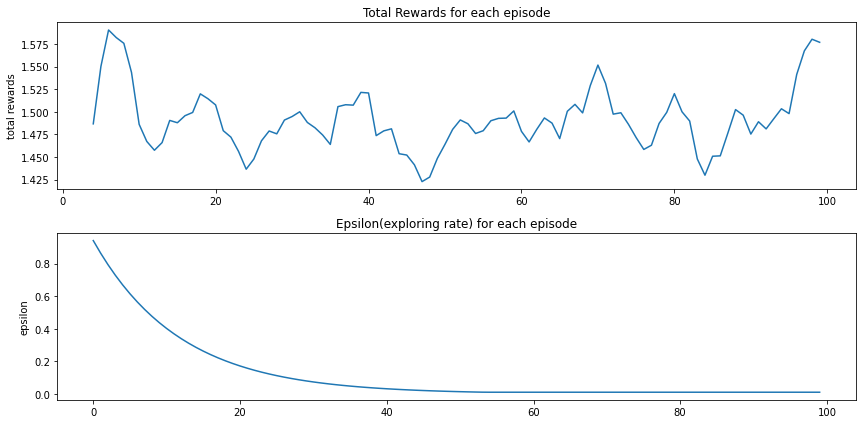

In [44]:
training_plot(history_1)

## 5.2 Policy Gradient

In [48]:
# initialization for agent and environment
env = market_envrionment()
state = env.reset()
state_size = env.observation_space[0] # given from environment
action_size = env.action_space.shape[0]
agent_pg = PGAgent(state_size, action_size)

# hyper-parameter and containers
score = 0
episode = 0
training_years = 17
total_episodes = 100
verbose = True
history_2 = []

for episode in tqdm(range(total_episodes)):

    state = env.reset()
    score = 0

    for _ in range(training_years):

        start_time = time.time()
        action, prob = agent_pg.act(state)
        state, reward, done = env.step(action)
        score += reward
        agent_pg.memorize(state, action, prob, reward)
        if done:
            break

    # update agent at the end of each episod
    agent_pg.train()
    if verbose:
        print('Episode: %d - Score: %.2f - time: %.2f' % (episode, score, time.time()-start_time))
    history_2.append([episode, score])
    if episode > 1 and episode % 10 == 0:
        agent_pg.save('model_pg.h5')

  0%|          | 0/100 [00:00<?, ?it/s]Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
states (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 24)           48          states[0][0]                     
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 24)           600         dense_12[0][0]                   
__________________________________________________________________________________________________
rewards (InputLayer)            [(None, 1)]          0                                            
________________________________________________

visulization

Text(0, 0.5, 'total rewards')

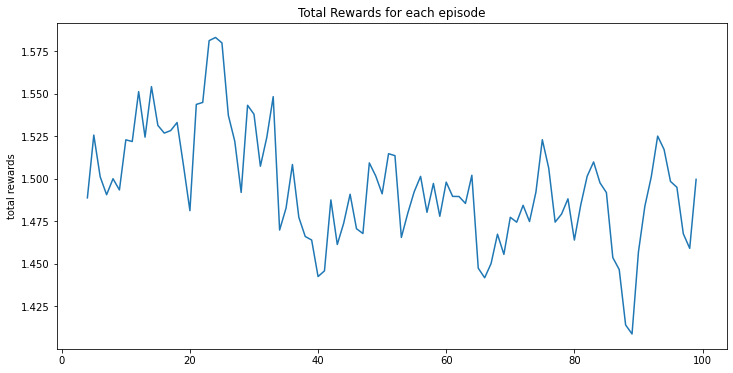

In [52]:
df_2 = pd.DataFrame(history_2, columns =["episode",'reward'])
plt.figure(figsize=(12, 6))
plt.plot(df_2.index, df_2['reward'].rolling(5).mean())
plt.title('Total Rewards for each episode')
plt.ylabel('total rewards')
plt.savefig

# 6. Performance Analysis

We test trained agents to select optimal shrinkage intensity on historical data

In [77]:
state = env.reset()
action_pg = []
while not done:
    action, prob = agent_pg.act(state)
    action_pg.append(action * 0.1)
    state, reward, done = env.step(action)

<AxesSubplot:title={'center':'Optimal(Policy Gradient) Shrinkage Intensity Prediction'}>

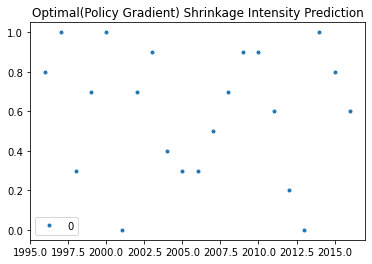

In [80]:
action_pg_df = pd.DataFrame(action_pg, index= np.arange(1996, 2017))
action_pg_df.plot(style = '.',
                           title = 'Optimal(Policy Gradient) Shrinkage Intensity Prediction')

In [85]:
state = env.reset()
action_dqn = []
while not done:
    action = agent.act(state)
    action_dqn.append(action * 0.1)
    state, reward, done = env.step(action)

<AxesSubplot:title={'center':'Optimal(DQN) Shrinkage Intensity Prediction'}>

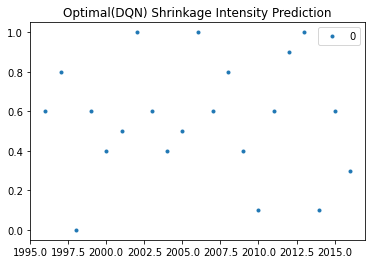

In [83]:
action_dqn_df = pd.DataFrame(action_dqn, index= np.arange(1996, 2017))
action_dqn_df.plot(style = '.',
                           title = 'Optimal(DQN) Shrinkage Intensity Prediction')

# 7. Statistical Test on 3 Different Approaches
We compare navive approach, Ledoit and Wolf (linear and non-linear) method and OAS method in this section. Also the test performance varies according to shrinkage target selection. So we follow the same pipeline (1. construct shrunk portfolio 2. backtest to get performace(Sharp ratio) 3. statistical analysis) to test on three different shrinkage targets.

In [20]:
import nonlinshrink as nls
from sklearn.covariance import LedoitWolf
from sklearn.covariance import OAS
from scipy.stats import moment

In [21]:
def get_shrank_cov(correlated_matrix, shrink_target, volatility_vector, a):
    # initialization
    R_1 = correlated_matrix.values
    R_2 = shrink_target.values
    D = np.diag(volatility_vector) 
    one = np.ones(D.shape[0])

    # cov calculation
    R_3 = (1 - a) * R_1 + a * R_2 # new shrank correlated matrix
    H = D @ R_3 @ D # new shrank covariance matrix

    return H

In [22]:
def get_GMVP(shrank_covariance, volatility_vector):
    D = np.diag(volatility_vector) 
    one = np.ones(D.shape[0])
    H = shrank_covariance

    # pre calculation
    H_inv = inv(H)
    numerator = H_inv @ one
    denominator = one.T @ H_inv @ one

    # GMV porfolio
    x = numerator / denominator

    #return pd.DataFrame(H)
    return x.reshape((len(x), 1))

In [132]:
def backtest_get_portfolio_return(start, end, shrink_target):
    '''Build GMVP at the end of each year and compute portfolio return on the next year

    Required function:
        get_GMVP - calculate portfolio weights
        get_shrank_cov
    Args:
        start: beginning year
        end: ending year
    Returns:
        daily portfolio return time series
        n * 252 time series (n: # of alpha range)
    '''

    # initialization
    year_range = np.arange(start, end + 1)
    performance_matrix = pd.DataFrame()
    methods_list = ['shrink 0 pct', 
                    'shrink 50 pct', 
                    'shrink 100 pct',
                    'linear shrinkage',
                    'non-linear',
                    'OAS']

    for i in year_range:

        # initialization
        date_first = stock_date.searchsorted(datetime(i + 1, 1, 1))
        date_last = stock_date.searchsorted(datetime(i + 2, 1, 1))
        date_index = stock_date[date_first:date_last]

        # calculate shrank covariance
        cov_0 = get_shrank_cov(correlation_aggregate.loc[i],
                               shrink_target.loc[i],
                               volatility_aggregate.loc[i], 0)
        cov_50 = get_shrank_cov(correlation_aggregate.loc[i],
                               shrink_target.loc[i],
                               volatility_aggregate.loc[i], 0.5)
        cov_100 = get_shrank_cov(correlation_aggregate.loc[i],
                               shrink_target.loc[i],
                               volatility_aggregate.loc[i], 1)
        cov_lin = LedoitWolf().fit(stock_returns.loc[i]).covariance_
        cov_oas = OAS().fit(stock_returns.loc[i]).covariance_
        cov_nonlin = nls.shrink_cov(stock_returns.loc[i])

        # compute shrank portfolio (1 by n row vector)
        x_0 = get_GMVP(cov_0, volatility_aggregate.loc[i]).T
        x_50 = get_GMVP(cov_50, volatility_aggregate.loc[i]).T
        x_100 = get_GMVP(cov_100, volatility_aggregate.loc[i]).T
        x_lin = get_GMVP(cov_lin, volatility_aggregate.loc[i]).T
        x_nonlin = get_GMVP(cov_nonlin, volatility_aggregate.loc[i]).T
        x_oas = get_GMVP(cov_oas, volatility_aggregate.loc[i]).T
        
        # get stock return for the next year
        Y = stock_returns.loc[i + 1].values.T # n by 252 matrix

        # compute portfolios return for the next year (6 by 252 matrix)
        portfolios = np.concatenate((x_0, x_50, x_100, x_lin, x_nonlin, x_oas))
        R_p = pd.DataFrame((portfolios @ Y).T)
        R_p.index = date_index

        # compute Sharpe ratio
        SR = sharpe_ratio(R_p)

        # store data
        performance_matrix[i + 1] = SR.values.flatten()

    performance_matrix = performance_matrix.T
    performance_matrix.columns = methods_list

    return performance_matrix

In [138]:
# compute statistics for performance matrix
performance_matrix = backtest_get_portfolio_return(1996,2017, tbn_combined)
statistics_TBN = performance_matrix.describe().drop('count').T
statistics_TBN.insert(loc = 2, column = 'skewness',value = performance_matrix.skew())
statistics_TBN.insert(loc = 3, column = 'kurtosis',value = performance_matrix.kurtosis())
statistics_TBN.T

,shrink 0 pct,shrink 50 pct,shrink 100 pct,linear shrinkage,non-linear,OAS
mean,0.570269,0.457837,0.374985,0.617957,0.591669,0.598039
std,0.827262,0.837339,1.200127,0.832114,0.829660,0.833494
skewness,0.100723,0.018710,-0.578672,0.220716,0.198135,0.166657
kurtosis,-0.394558,-0.874358,0.097834,-0.314266,-0.270590,-0.346162
min,-0.997900,-1.060554,-2.484602,-0.831503,-0.934247,-0.924112
25%,0.043538,-0.156461,-0.322805,0.122116,0.113124,0.083471
50%,0.556955,0.435143,0.478084,0.530163,0.469034,0.532853
75%,1.089416,1.077236,1.053372,1.084535,1.055794,1.083906
max,2.141238,1.962221,2.220851,2.312856,2.277912,2.245206


## 7.2 Change for Identity Matrix and Scaled TBN

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
year_start = 1996
year_end = 2017
df_scaled_combined = pd.DataFrame()
df_identity_combined = pd.DataFrame()
for i in np.arange(year_start, year_end + 1):
    df_scaled = pd.DataFrame(StandardScaler().fit_transform(tbn_combined.loc[i]), index=[i] * 23)
    df_identity = pd.DataFrame(np.identity(23), index=[i] * 23)
    df_scaled_combined = df_scaled.append(df_scaled_combined)
    df_identity_combined = df_identity.append(df_identity_combined)

In [137]:
# compute statistics for identity matrix
performance_matrix = backtest_get_portfolio_return(1996,2017, df_identity_combined)
statistics_id = performance_matrix.describe().drop('count').T
statistics_id.insert(loc = 2, column = 'skewness',value = performance_matrix.skew())
statistics_id.insert(loc = 3, column = 'kurtosis',value = performance_matrix.kurtosis())
statistics_id.T

,shrink 0 pct,shrink 50 pct,shrink 100 pct,linear shrinkage,non-linear,OAS
mean,0.570269,0.715518,0.826949,0.617957,0.591669,0.598039
std,0.827262,0.892961,0.958998,0.832114,0.829660,0.833494
skewness,0.100723,0.613549,0.754595,0.220716,0.198135,0.166657
kurtosis,-0.394558,0.771022,1.209482,-0.314266,-0.270590,-0.346162
min,-0.997900,-0.602185,-0.633502,-0.831503,-0.934247,-0.924112
25%,0.043538,0.096474,0.044075,0.122116,0.113124,0.083471
50%,0.556955,0.785626,0.927632,0.530163,0.469034,0.532853
75%,1.089416,1.059937,1.204106,1.084535,1.055794,1.083906
max,2.141238,2.971447,3.358311,2.312856,2.277912,2.245206


In [136]:
# compute statistics for scaled TBN
performance_matrix = backtest_get_portfolio_return(1996,2017, df_scaled_combined)
statistics_scaled = performance_matrix.describe().drop('count').T
statistics_scaled.insert(loc = 2, column = 'skewness',value = performance_matrix.skew())
statistics_scaled.insert(loc = 3, column = 'kurtosis',value = performance_matrix.kurtosis())
statistics_scaled.T

,shrink 0 pct,shrink 50 pct,shrink 100 pct,linear shrinkage,non-linear,OAS
mean,0.570269,-0.107652,0.185268,0.617957,0.591669,0.598039
std,0.827262,1.233194,1.087677,0.832114,0.829660,0.833494
skewness,0.100723,0.016754,-0.391751,0.220716,0.198135,0.166657
kurtosis,-0.394558,-0.559147,0.468850,-0.314266,-0.270590,-0.346162
min,-0.997900,-2.440214,-2.358890,-0.831503,-0.934247,-0.924112
25%,0.043538,-0.916301,-0.415789,0.122116,0.113124,0.083471
50%,0.556955,-0.302844,0.122880,0.530163,0.469034,0.532853
75%,1.089416,0.714129,0.947005,1.084535,1.055794,1.083906
max,2.141238,2.158873,2.175455,2.312856,2.277912,2.245206


In [142]:
statistics_TBN.T.to_latex('../output/statistics_TBN.tex', bold_rows = True)
statistics_scaled.T.to_latex('../output/statistics_scaled.tex', bold_rows = True)
statistics_id.T.to_latex('../output/statistics_id.tex', bold_rows = True)

# 8 New Backtesting (Sharpe ratio for whole period)

In [36]:
def backtest_get_portfolio_return(start, end, shrink_target):
    '''Build GMVP at the end of each year and compute portfolio return on the next year

    Required function:
        get_GMVP - calculate portfolio weights
        get_shrank_cov
    Args:
        start: beginning year
        end: ending year
    Returns:
        daily portfolio return time series
        n * 252 time series (n: # of alpha range)
    '''

    # initialization
    year_range = np.arange(start, end + 1)
    performance_matrix = pd.DataFrame()
    methods_list = ['shrink 0 pct', 
                    'shrink 50 pct', 
                    'shrink 100 pct',
                    'linear shrinkage',
                    'non-linear',
                    'OAS']
    R_p_store = pd.DataFrame([])

    for i in year_range:

        # initialization
        date_first = stock_date.searchsorted(datetime(i + 1, 1, 1))
        date_last = stock_date.searchsorted(datetime(i + 2, 1, 1))
        date_index = stock_date[date_first:date_last]

        # calculate shrank covariance
        cov_0 = get_shrank_cov(correlation_aggregate.loc[i],
                               shrink_target.loc[i],
                               volatility_aggregate.loc[i], 0)
        cov_50 = get_shrank_cov(correlation_aggregate.loc[i],
                               shrink_target.loc[i],
                               volatility_aggregate.loc[i], 0.5)
        cov_100 = get_shrank_cov(correlation_aggregate.loc[i],
                               shrink_target.loc[i],
                               volatility_aggregate.loc[i], 1)
        cov_lin = LedoitWolf().fit(stock_returns.loc[i]).covariance_
        cov_oas = OAS().fit(stock_returns.loc[i]).covariance_
        cov_nonlin = nls.shrink_cov(stock_returns.loc[i])

        # compute shrank portfolio (1 by n row vector)
        x_0 = get_GMVP(cov_0, volatility_aggregate.loc[i]).T
        x_50 = get_GMVP(cov_50, volatility_aggregate.loc[i]).T
        x_100 = get_GMVP(cov_100, volatility_aggregate.loc[i]).T
        x_lin = get_GMVP(cov_lin, volatility_aggregate.loc[i]).T
        x_nonlin = get_GMVP(cov_nonlin, volatility_aggregate.loc[i]).T
        x_oas = get_GMVP(cov_oas, volatility_aggregate.loc[i]).T
        
        # get stock return for the next year
        Y = stock_returns.loc[i + 1].values.T # n by 252 matrix

        # compute portfolios return for the next year (6 by 252 matrix)
        portfolios = np.concatenate((x_0, x_50, x_100, x_lin, x_nonlin, x_oas))
        R_p = pd.DataFrame((portfolios @ Y).T)
        R_p.index = date_index

        # store return data
        R_p_store =R_p_store.append(R_p)

    # compute Sharpe ratio
    SR = sharpe_ratio(R_p_store).T
    SR.columns = methods_list

    return SR.T

In [3]:
# compute statistics for performance matrix
performance_matrix = backtest_get_portfolio_return(1996,2017, tbn_combined)
statistics_TBN = performance_matrix.describe().drop('count').T
statistics_TBN.insert(loc = 2, column = 'skewness',value = performance_matrix.skew())
statistics_TBN.insert(loc = 3, column = 'kurtosis',value = performance_matrix.kurtosis())
statistics_TBN.T

In [41]:
performance_matrix = pd.DataFrame()
performance_matrix['TBN'] = backtest_get_portfolio_return(1996,2017, tbn_combined).values.flatten()
performance_matrix['Scaled TBN'] = backtest_get_portfolio_return(1996,2017, df_scaled_combined).values.flatten()
performance_matrix['Identity'] = backtest_get_portfolio_return(1996,2017, df_identity_combined).values.flatten()
methods_list = ['shrink 0 pct', 
                'shrink 50 pct', 
                'shrink 100 pct',
                'linear shrinkage',
                'non-linear',
                'OAS']
performance_matrix.index = methods_list
performance_matrix.T

,shrink 0 pct,shrink 50 pct,shrink 100 pct,linear shrinkage,non-linear,OAS
TBN,0.444084,0.349595,-0.430668,0.471745,0.449374,0.459414
Scaled TBN,0.444084,-0.130572,0.387176,0.471745,0.449374,0.459414
Identity,0.444084,0.507769,0.573233,0.471745,0.449374,0.459414


In [42]:
performance_matrix.T.to_csv('../output/sharpe_ratio_of_3_targets_6_methods.csv')

In [43]:
performance_matrix.T.to_latex('../output/sharpe_ratio_of_3_targets_6_methods.tex')